## A demo using two-qubit HeisenbergModel Hamiltonian with GPT-QE (using minGPT code).

In [15]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from gqe.mingpt.utils import set_seed

set_seed(3407)

In [16]:
from qwrapper.hamiltonian import HeisenbergModel
from qwrapper.operator import PauliObservable
from gqe.mingpt.cost import EnergyCost
from qswift.initializer import ZBasisInitializer
from qswift.compiler import DefaultOperatorPool

obs = HeisenbergModel(2)
initializer = ZBasisInitializer()
pool = DefaultOperatorPool([PauliObservable("XI"), PauliObservable("YI"),
                            PauliObservable("ZI"), PauliObservable("IX"),
                            PauliObservable("IY"), PauliObservable("IZ"),
                            PauliObservable("XX"), PauliObservable("YY"), PauliObservable("ZZ")])
cost = EnergyCost(obs, initializer, pool, [0.05, -0.05, 0.1, -0.1, 0.2, -0.2, 0.4, -0.4])


## FCI energy by diagonalization

In [17]:
from qwrapper.hamiltonian import compute_ground_state

print(compute_ground_state(obs))

-6.0


## Setup for GPT

In [18]:
# create a GPT instance
from gqe.mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt2'
model_config.vocab_size = cost.vocab_size()
model_config.block_size = cost.vocab_size()
model_config.n_gates = 30  # The number of gates for each circuit
model_config.n_samples = 5
model_config.temperature = 10  # Each gate is generated with probability exp(-temperature * logit)
model = GPT(model_config, cost)

number of parameters: 85.17M


In [19]:
# create a Trainer object
from gqe.mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-7  # the model we're using is so small that we can go a bit faster
train_config.max_iters = 1000
train_config.num_workers = 0
trainer = Trainer(train_config, model)

running on device cpu


In [20]:
def batch_end_callback(trainer):
    if trainer.iter_num % 10 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        model.temperature += 0.1


trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()
torch.save(model.state_dict(), '../saved_models/gptqe_heisenberg')

energies: tensor([-0.7202, -3.3854,  0.9057,  0.8759,  1.7026])
mean: tensor(-0.1243)
iter_dt 0.00ms; iter 0: train loss 4.47857
energies: tensor([-2.7038, -1.3870,  1.0807,  0.0284, -1.3544])
mean: tensor(-0.8672)
energies: tensor([ 1.3900,  1.8234,  1.1278,  1.5837, -2.4290])
mean: tensor(0.6992)
energies: tensor([1.7305, 1.9152, 0.6946, 1.2756, 0.7515])
mean: tensor(1.2735)
energies: tensor([ 0.6075,  1.1890, -1.0357, -2.3526, -0.9729])
mean: tensor(-0.5129)
energies: tensor([ 0.8976, -1.2819,  1.4833,  1.9181, -0.5822])
mean: tensor(0.4870)
energies: tensor([-1.4113,  0.1237, -2.0791,  1.8893, -0.9331])
mean: tensor(-0.4821)
energies: tensor([ 0.6655, -1.6614, -0.5726, -0.1167,  0.5353])
mean: tensor(-0.2300)
energies: tensor([-0.4877, -0.3453, -1.3326, -0.8433,  1.6171])
mean: tensor(-0.2784)
energies: tensor([ 0.3215, -0.6340, -0.8967,  0.5449,  1.1425])
mean: tensor(0.0956)
energies: tensor([-3.1902,  1.8668,  1.5627, -0.5334,  0.2809])
mean: tensor(-0.0026)
iter_dt 49732.59ms; 

<All keys matched successfully>

In [21]:
model.load_state_dict(torch.load('../saved_models/gptqe_heisenberg'))

<All keys matched successfully>

tensor([34, 34, 34, 34, 22, 34, 22, 34, 30, 34, 22, 30, 22, 34, 30, 22, 30, 22,
        30, 22, 30, 22, 30, 22, 30, 22, 30, 22, 30, 22])


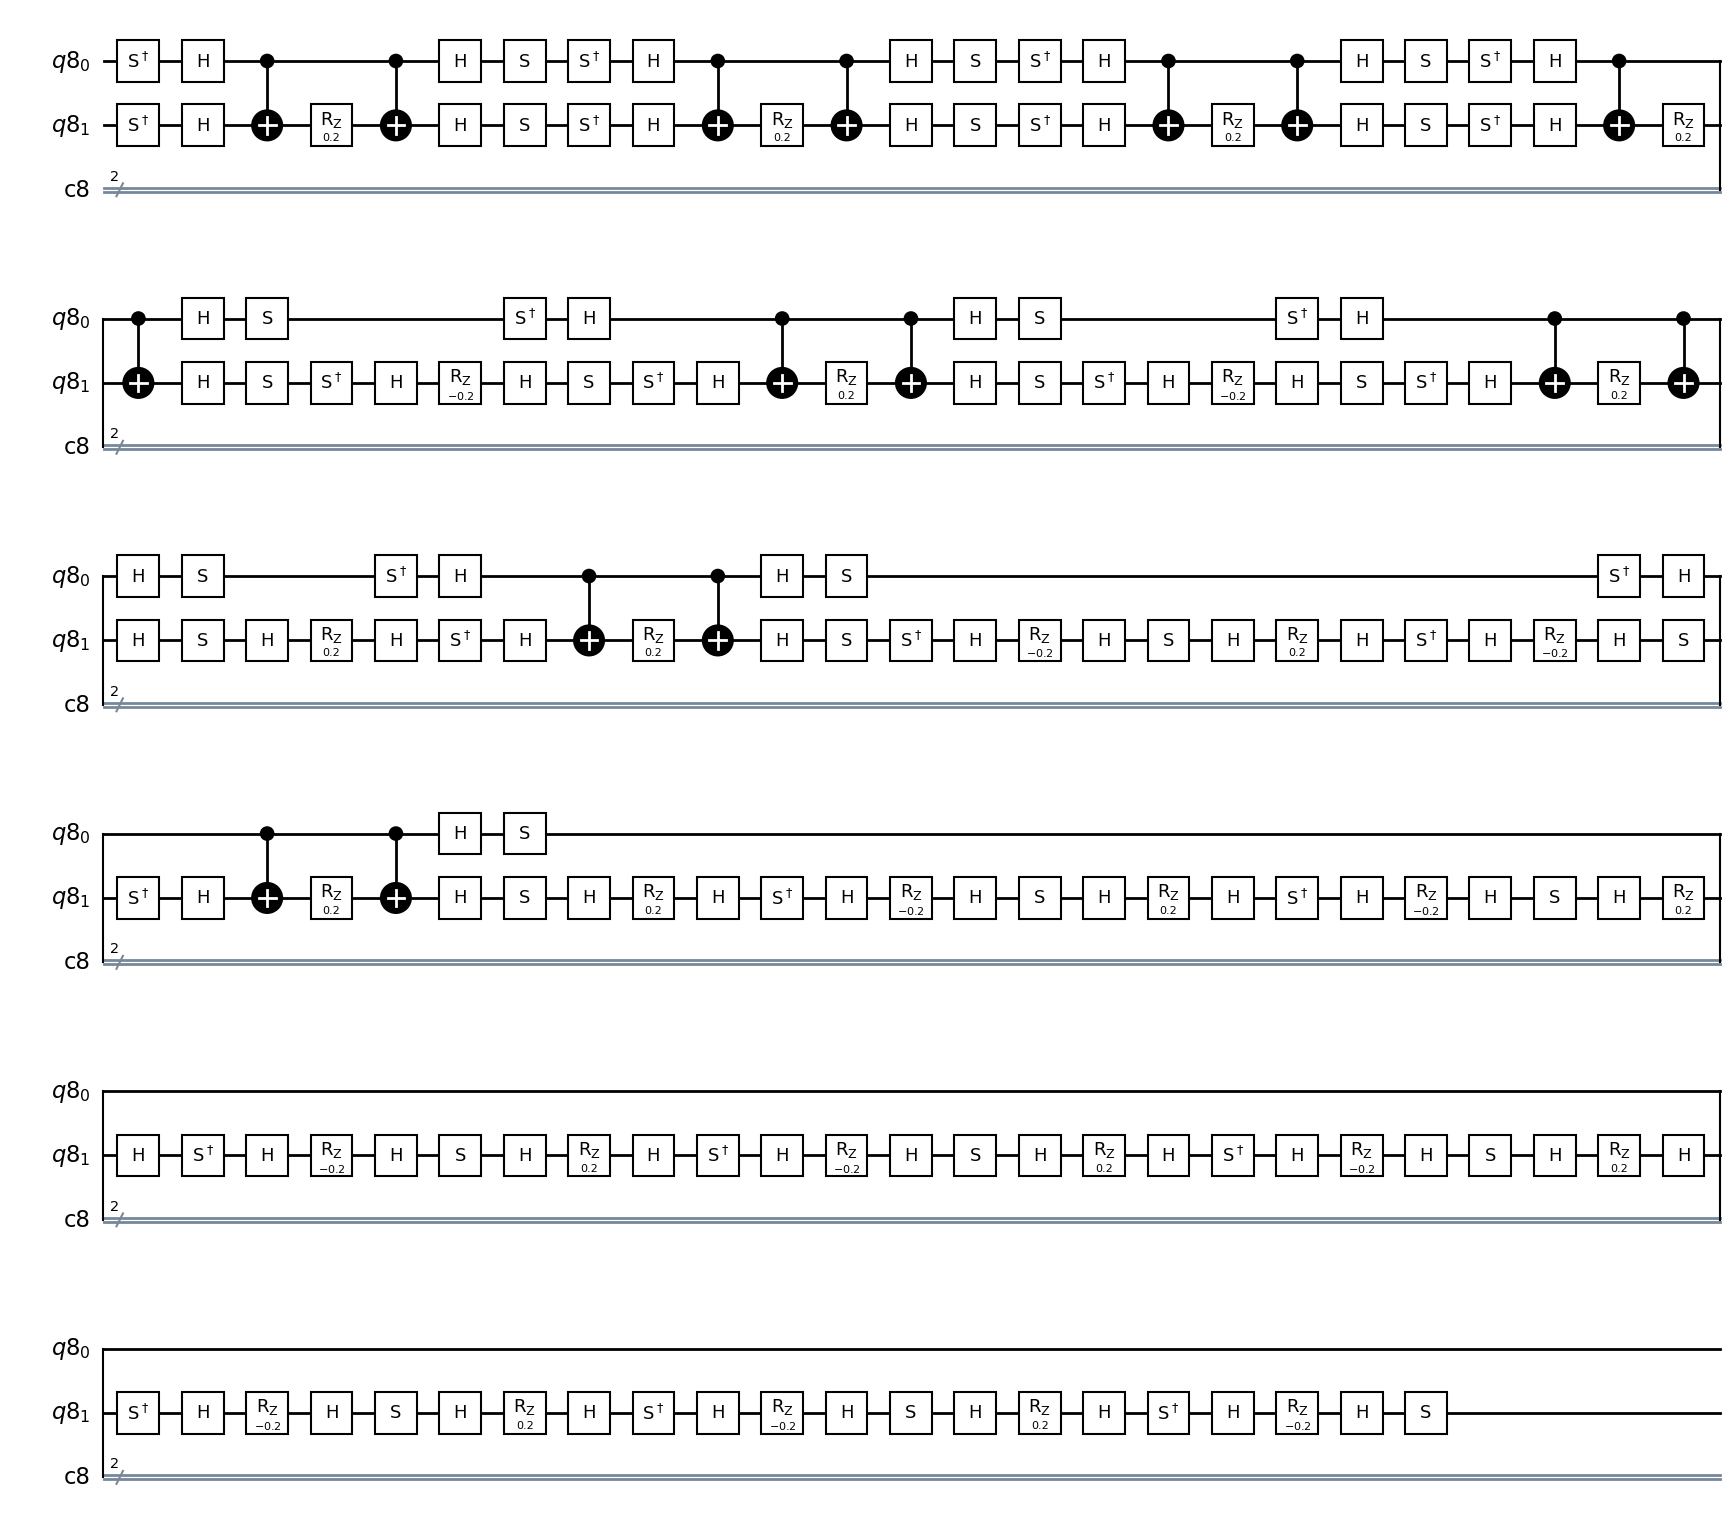

In [40]:
indices, logits = model.generate(torch.tensor([[0]]), 30)
cost.sequence.tool = "qiskit"
print(indices[0][1:])
cost.sequence._get_circuit(indices[0][1:].numpy()).draw()